<a href="https://colab.research.google.com/github/mmistroni/TensorFlowPlayground/blob/master/TFTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>


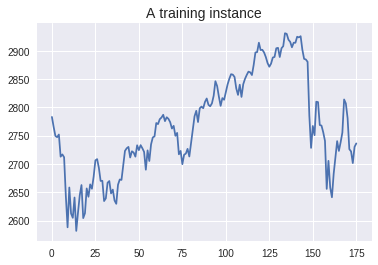

In [0]:
stock_data.shape[0]
print (type(stock_data))
adjClose = np.stack(stock_data['Close'])

# Since we always want to predict the future, we take the latest 10% of data as the test data.
# Split into train / test so that you can use the test to find accuracy.
# Train is used to train, and test to predict, to see the accuracy, Then we can use last price today to predict tomorrow, and so on

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.title("A training instance", fontsize=14)
plt.plot(adjClose)



In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
!pip install pandas_datareader




In [29]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.contrib.learn import ModeKeys
import tensorflow.contrib.rnn as rnn
from datetime import datetime

#tf.logging.set_verbosity(tf.logging.INFO)

#TIMESERIES_COL = '9'
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 6  # in each sequence, 1-14 are features, and 14-20 is label 
SEQ_LEN = 20
DEFAULTS = 0.0
N_INPUTS = SEQ_LEN - N_OUTPUTS
BATCH_SIZE = 20
ROOT_DIR = '/home/mmistroni/tf_logs/rnn-run-{}'


def get_prices():
  import pandas_datareader as pdr
  from datetime import date, timedelta
  startdate = date.today() - timedelta(days=100)
  stock_data = pdr.get_data_yahoo('XOM', startdate, date.today())[-SEQ_LEN:]
  adjClose = np.stack(stock_data['Close'])
  return adjClose.T
  

def create_time_series():
  return get_prices()
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

prices  = get_prices()
print('type of prices:{}', type(prices))
print('lenght of prices:{}', len(prices))

type of prices:{} <class 'numpy.ndarray'>
lenght of prices:{} 20


In [30]:
all_timeseries = [create_time_series() for i in range(0, SEQ_LEN * 4)]


# We need to stack X numpy array on top of each other and then create a dictionary
# for every features
column_names = [str(idx) for idx in range(0, SEQ_LEN)]

feature_names = column_names[0:-N_OUTPUTS]
labels = column_names[-N_OUTPUTS:]
all_data = np.stack(all_timeseries)

print('All data shape is{0}'.format(all_data.shape))
X, y = all_data[...,0:-N_OUTPUTS], all_data[...,-N_OUTPUTS:]

print ('X is fo type {0}, y  of type {1}'.format(type(X[0][0]), type(y)))


print ('X.shape is {0}, y shap is {1}'.format(X.shape, y.shape))


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1)




features_train = dict((fn,X_train[:, [idx]]) for idx, fn in enumerate(feature_names))
labels_train = y_train


# Test data
features_test = dict((fn,X_test[:, [idx]]) for idx, fn in enumerate(feature_names))
labels_test = y_test



LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, labels, mode, params):
  # 0. Reformat input shape to become a sequence
  print ('IN Features are:{0}'.format(features))
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
  #print 'x={}'.format(x)
    
  # 1. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

  # slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  #print 'last outputs={}'.format(outputs)
  
  # output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. loss function, training/eval ops
  if mode == ModeKeys.TRAIN or mode == ModeKeys.EVAL:
     loss = tf.losses.mean_squared_error(labels, predictions)
     train_op = tf.contrib.layers.optimize_loss(
         loss=loss,
         global_step=tf.train.get_global_step(),
         learning_rate=0.01,
         optimizer="SGD")
     eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
     }
  else:
     loss = None
     train_op = None
     eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}

  # 4. Create export outputs  
  export_outputs = {"predicted": tf.estimator.export.PredictOutput(predictions)}

  # 5. return ModelFnOps
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs=export_outputs)

def serving_input_receiver_fn():
  feature_placeholders = {
    TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }

  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }

  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2], name='timeseries')
  
  print('serving: features={}'.format(features[TIMESERIES_COL]))

  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)



# Creating a TrainFn and a TestFn
def _train_fn(X, y, batch_size):
    
    def _train():
        """An input function for training"""
        # Convert the inputs to a Dataset.
        # TODO need to be refactored according to https://medium.com/google-cloud/how-to-do-time-series-prediction-using-rnns-and-tensorflow-and-cloud-ml-engine-2ad2eeb189e8
        # this is not good.
        X_32 = tf.cast(X, tf.float32)
        y_32 = tf.cast(y, tf.float32)
        inputs = tf.concat(X_32, axis=1)
        label = tf.concat(y_32, axis=1)
        features, labels = {TIMESERIES_COL: inputs}, label
        
        return features, labels
        dataset = tf.data.Dataset.from_tensor_slices(features, labels)
        # Shuffle, repeat, and batch the examples.
        dataset = dataset.repeat(None).batch(batch_size)
        # This will now return batches of features, label
        return dataset.make_one_shot_iterator().get_next()
    return _train

def _test_fn(X, y, batch_size):
    def _test():
        """An input function for training"""
        # Convert the inputs to a Dataset.
        X_32 = tf.cast(X, tf.float32)
        y_32 = tf.cast(y, tf.float32)
        inputs = tf.concat(X_32, axis=1)
        label = tf.concat(y_32, axis=1)
        
        features, labels = {TIMESERIES_COL: inputs}, label
        
        return features, labels
        
        dataset = tf.data.Dataset.from_tensor_slices(features, labels)
        # Shuffle, repeat, and batch the examples.
        dataset = dataset.repeat(1).batch(batch_size)
        # This will now return batches of features, label
        return dataset.make_one_shot_iterator().get_next()
    return _test  
  
 
def experiment_fn(output_dir):
    # run experiment
    train_spec = tf.estimator.TrainSpec(
          input_fn=_train_fn(X_train, y_train, BATCH_SIZE), max_steps=1500)
    exporter = tf.estimator.FinalExporter('timeseries',
    serving_input_receiver_fn)
    eval_spec = tf.estimator.EvalSpec(
            input_fn=_test_fn(X_test, y_test, BATCH_SIZE), 
            exporters=[exporter])
    
    estimator = tf.estimator.Estimator(model_fn=simple_rnn, model_dir=output_dir)

    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

tf.logging.set_verbosity(tf.logging.INFO)    
    
output_dir = ROOT_DIR.format(datetime.utcnow().strftime('%Y%m%d%H%M%S'))  
  
experiment_fn(output_dir)


All data shape is(80, 20)
X is fo type <class 'numpy.float64'>, y  of type <class 'numpy.ndarray'>
X.shape is (80, 14), y shap is (80, 6)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/mmistroni/tf_logs/rnn-run-20181127214854', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f66d94b8a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, 

Installing libraries and downloading data as DataFrame


In [2]:
!pip install pandas_datareader

    100% |████████████████████████████████| 112kB 4.2MB/s 
    100% |████████████████████████████████| 5.8MB 4.8MB/s 


In [0]:
import pandas_datareader as pdr
from datetime import date, timedelta
startdate = date.today() - timedelta(days=100)
stock_data = pdr.get_data_yahoo('^GSPC', startdate, date.today())

Creating 10 batches of 10 Items

In [0]:
closes = stock_data[['Close']]




In [0]:
def init(hparams):
    global SEQ_LEN, DEFAULTS, N_INPUTS
    N_OUTPUTS = 3  # in each sequence, 1-9 are features, and 10 is label
    SEQ_LEN = 10
    DEFAULTS = 0.0
    DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
    N_INPUTS = SEQ_LEN - N_OUTPUTS


def linear_model(features, mode, params):
    X = features[TIMESERIES_COL]
    predictions = tf.layers.dense(X, 1, activation=None)
    return predictions


def dnn_model(features, mode, params):
    X = features[TIMESERIES_COL]
    h1 = tf.layers.dense(X, 10, activation=tf.nn.relu)
    h2 = tf.layers.dense(h1, 3, activation=tf.nn.relu)
    predictions = tf.layers.dense(h2, 1, activation=None)  # linear output: regression
    return predictions



In [0]:
def cnn_model(features, mode, params):
    X = tf.reshape(features[TIMESERIES_COL],
                   [-1, N_INPUTS, 1])  # as a 1D "sequence" with only one time-series observation (height)
    c1 = tf.layers.conv1d(X, filters=N_INPUTS // 2,
                          kernel_size=3, strides=1,
                          padding='same', activation=tf.nn.relu)
    p1 = tf.layers.max_pooling1d(c1, pool_size=2, strides=2)

    c2 = tf.layers.conv1d(p1, filters=N_INPUTS // 2,
                          kernel_size=3, strides=1,
                          padding='same', activation=tf.nn.relu)
    p2 = tf.layers.max_pooling1d(c2, pool_size=2, strides=2)

    outlen = p2.shape[1] * p2.shape[2]
    c2flat = tf.reshape(p2, [-1, outlen])
    h1 = tf.layers.dense(c2flat, 3, activation=tf.nn.relu)
    predictions = tf.layers.dense(h1, 1, activation=None)  # linear output: regression
    return predictions


In [0]:
def rnn_model(features, mode, params):
    CELL_SIZE = N_INPUTS // 3  # size of the internal state in each of the cells

    # 1. dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
    x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])

    # 2. configure the RNN
    cell = tf.nn.rnn_cell.GRUCell(CELL_SIZE)
    outputs, state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float64)

    # 3. pass rnn output through a dense layer
    h1 = tf.layers.dense(state, N_INPUTS // 2, activation=tf.nn.relu)
    predictions = tf.layers.dense(h1, 1, activation=None)  # (?, 1)
    return predictions


# 2-layer RNN
def rnn2_model(features, mode, params):
    # dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
    x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])

    # 2. configure the RNN
    cell1 = tf.nn.rnn_cell.GRUCell(N_INPUTS * 2)
    cell2 = tf.nn.rnn_cell.GRUCell(N_INPUTS // 2)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
    outputs, state = tf.nn.dynamic_rnn(cells, x, dtype=tf.float32)
    # 'state' is now a tuple containing the final state of each cell layer
    # we use state[1] below to extract the final state of the final layer
    
    # 3. pass rnn output through a dense layer
    h1 = tf.layers.dense(state[1], cells.output_size // 2, activation=tf.nn.relu)
    predictions = tf.layers.dense(h1, 1, activation=None)  # (?, 1)
    return predictions

In [0]:
def rnnN_model(features, mode, params):
    # dynamic_rnn needs 3D shape: [BATCH_SIZE, N_INPUTS, 1]
    x = tf.reshape(features[TIMESERIES_COL], [-1, N_INPUTS, 1])

    # 2. configure the RNN
    cell1 = tf.nn.rnn_cell.GRUCell(N_INPUTS * 2)
    cell2 = tf.nn.rnn_cell.GRUCell(N_INPUTS // 2)
    cells = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
    outputs, state = tf.nn.dynamic_rnn(cells, x, dtype=tf.float32)
    # 'outputs' contains the state of the final layer for every time step
    # not just the last time step (?,N_INPUTS, final cell size)
    
    # 3. pass state for each time step through a DNN, to get a prediction
    # for each time step 
    h1 = tf.layers.dense(outputs, cells.output_size, activation=tf.nn.relu)
    h2 = tf.layers.dense(h1, cells.output_size // 2, activation=tf.nn.relu)
    predictions = tf.layers.dense(h2, 1, activation=None)  # (?, N_INPUTS, 1)
    predictions = tf.reshape(predictions, [-1, N_INPUTS])
    return predictions # return prediction for each time step

In [0]:
# read data and convert to needed format
def read_dataset(filename, mode, batch_size=10):
    # What we  need to do here is to somehow pass a 10*10 dataset. and we should not use decode_csv but rather do similar
    # to what we have done in the california dtaset
    def _input_fn():
        def decode_csv(row):
            # row is a string tensor containing the contents of one row
            features = tf.decode_csv(row, record_defaults=DEFAULTS)  # string tensor -> list of 50 rank 0 float tensors
            label = features.pop()  # remove last feature and use as label
            features = tf.stack(features)  # list of rank 0 tensors -> single rank 1 tensor
            return {TIMESERIES_COL: features}, label

        # Create list of file names that match "glob" pattern (i.e. data_file_*.csv)
        dataset = tf.data.Dataset.list_files(filename)
        # Read in data from files
        dataset = dataset.flat_map(tf.data.TextLineDataset)
        # Parse text lines as comma-separated values (CSV)
        dataset = dataset.map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None  # loop indefinitely
            dataset = dataset.shuffle(buffer_size=10 * batch_size)
        else:
            num_epochs = 1  # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()

    return _input_fn

In [0]:
def serving_input_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }

    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2])

    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

In [0]:
def compute_errors(features, labels, predictions):
    labels = tf.expand_dims(labels, -1)  # rank 1 -> rank 2 to match rank of predictions

    if predictions.shape[1] == 1:
        loss = tf.losses.mean_squared_error(labels, predictions)
        rmse = tf.metrics.root_mean_squared_error(labels, predictions)
        return loss, rmse
    else:
        # one prediction for every input in sequence
        # get 1-N of (x + label)
        labelsN = tf.concat([features[TIMESERIES_COL], labels], axis=1)
        labelsN = labelsN[:, 1:]
        # loss is computed from the last 1/3 of the series
        N = (2 * N_INPUTS) // 3
        loss = tf.losses.mean_squared_error(labelsN[:, N:], predictions[:, N:])
        # rmse is computed from last prediction and last label
        lastPred = predictions[:, -1]
        rmse = tf.metrics.root_mean_squared_error(labels, lastPred)
        return loss, rmse

In [0]:
# RMSE when predicting same as last value
def same_as_last_benchmark(features, labels):
    predictions = features[TIMESERIES_COL][:,-1] # last value in input sequence
    return tf.metrics.root_mean_squared_error(labels, predictions)


# create the inference model
def sequence_regressor(features, labels, mode, params):
    # 1. run the appropriate model
    model_functions = {
        'linear': linear_model,
        'dnn': dnn_model,
        'cnn': cnn_model,
        'rnn': rnn_model,
        'rnn2': rnn2_model,
        'rnnN': rnnN_model}
    model_function = model_functions[params['model']]
    predictions = model_function(features, mode, params)

    # 2. loss function, training/eval ops
    loss = None
    train_op = None
    eval_metric_ops = None
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        loss, rmse = compute_errors(features, labels, predictions)

        if mode == tf.estimator.ModeKeys.TRAIN:
            # this is needed for batch normalization, but has no effect otherwise
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # 2b. set up training operation
                train_op = tf.contrib.layers.optimize_loss(
                    loss,
                    tf.train.get_global_step(),
                    learning_rate=params['learning_rate'],
                    optimizer="Adam")

        # 2c. eval metric
        eval_metric_ops = {
            "RMSE": rmse,
            "RMSE_same_as_last": same_as_last_benchmark(features, labels),
        }

    # 3. Create predictions
    if predictions.shape[1] != 1:
        predictions = predictions[:, -1]  # last predicted value
    predictions_dict = {"predicted": predictions}

    # 4. return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions_dict,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops,
        export_outputs={
            'predictions': tf.estimator.export.PredictOutput(predictions_dict)}
    )

In [0]:
def train_and_evaluate(output_dir, hparams):
    #get_train = read_dataset(hparams['train_data_path'],
    #                         tf.estimator.ModeKeys.TRAIN,
    #                         hparams['train_batch_size'])
    #get_valid = read_dataset(hparams['eval_data_path'],
    #                         tf.estimator.ModeKeys.EVAL,
    #                         1000)
    
    get_train = _train_fn(features=features_train,
                                    labels=labels_train,
                                    batch_size=10)
    
    get_valid = _test_fn(features=features_test, 
                                      labels=labels_test,
                                      batch_size=10)
    
    estimator = tf.estimator.Estimator(model_fn=sequence_regressor,
                                       params=hparams,
                                       config=tf.estimator.RunConfig(
                                           save_checkpoints_secs=
                                           hparams['min_eval_frequency']),
                                       model_dir=output_dir)
    train_spec = tf.estimator.TrainSpec(input_fn=get_train,
                                        max_steps=hparams['train_steps'])
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(input_fn=get_valid,
                                      steps=None,
                                      exporters=exporter,
                                      start_delay_secs=hparams['eval_delay_secs'],
                                      throttle_secs=hparams['min_eval_frequency'])
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [14]:
# TODO : Check original example for shape of the data

tf.logging.set_verbosity(tf.logging.INFO)
EVAL_INTERVAL = 300
TRAIN_STEPS = 10000
EVAL_DELAY_SECS = 60
ROOT_DIR = '/home/mmistroni/tf_logs/run-{}'
hparams = dict(min_eval_frequency=EVAL_INTERVAL, train_steps=TRAIN_STEPS, eval_delay_secs = EVAL_DELAY_SECS, model='dnn')
from datetime import datetime
train_and_evaluate('/home/mmistroni/tf_logs/timeseries/run-{}-{}'.format(ROOT_DIR.format(datetime.utcnow().strftime('%Y%m%d%H%M%S')),
                                                                         hparams['model']), hparams)

TypeError: ignored